In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import scipy
import pickle
import operator
from antenna_temp import Antenna
import itertools
from tqdm import tqdm
from matplotlib import gridspec

In [2]:
with open("../config.json", 'r') as cfg:
    params = json.load(cfg)

antenna_params = params["antenna_params"]
opt_params = params["optimisation_params"]

In [3]:
def compute_possible_conf(N, verbose=0, jac=True, hess=True, maxiter=500):
    antenna_params["N"] = N
    opt_params["options"]["verbose"] = verbose
    opt_params["options"]["maxiter"] = maxiter
    antenna = Antenna(antenna_params)
    antenna.set_objective(weights=[1.0, 1.0])
    configurations = list(itertools.product(np.arange(antenna.n_currents), repeat=antenna.N))
    
    values = []
    for cfg in tqdm(configurations):
        antenna.set_configuration(cfg)
        antenna.set_positivity_bounds()
        f, _ = antenna.get_optimal_current_allocation(opt_params, 
                                                      x0=-np.ones(antenna.N), 
                                                      cons=False, 
                                                      jac=jac, 
                                                      hess=hess)
        values.append(f)
    return values, configurations

def currents_plot(N, values, conf, figsize=(20, 5), suffix=''):
    plt.figure(figsize=figsize, dpi=300)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    
    plt.subplot(gs[0])
    plt.plot(values, '.-r')
    plt.xlim([-0.5, len(values) - 0.5])
    plt.grid(True)

    plt.subplot(gs[1])
    plt.imshow(np.array(conf).T, interpolation='nearest', aspect='auto')
    plt.yticks(np.arange(0.5, N+0.5, 1), labels=[])
    plt.xticks(np.arange(0.5, len(conf)+0.5, 1), labels=[])
    plt.grid(b=True, which='major')
    
    plt.tight_layout()
    plt.savefig(f"../results/imgs_temp/{N}_currents_analysis_{suffix}.png")
    plt.show()

def save_data(N, values, conf, path='../results/calc_temp/'):
    pickle.dump({f"values_{N}": values, f"conf_{N}": conf}, open(path + f"{N}_currents_data.pickle", 'wb'))

def get_data(N, path='../results/calc_temp/'):
    temp = pickle.load(open(path + f"{N}_currents_data.pickle", 'rb'))
    values = temp[f"values_{N}"]
    conf = temp[f"conf_{N}"]
    return values, conf

def get_conf_dict(values, conf):
    return dict(zip(conf, values))

def gray_code(n):
    def gray_code_recurse (g, n):
        k = len(g)
        if n <= 0:
            return
        else:
            for i in range (k-1,-1,-1):
                char='1,' + g[i]
                g.append(char)
            for i in range (k-1,-1,-1):
                g[i]='0,' + g[i]
            gray_code_recurse(g,n-1)
    g = ['0', '1']
    gray_code_recurse(g,n-1)
    return g

def gray_code_repr(conf_dict):
    N = len(list(conf_dict.keys())[0])
    gray_conf = gray_code(N)
    conf_dict_gray = {}
    for k in gray_conf:
        conf_elem = tuple([int(e) for e in k.split(',')])
        conf_dict_gray[conf_elem] = conf_dict[conf_elem]
    return conf_dict_gray

def sorted_repr(conf_dict):
    sorted_dict = sorted(conf_dict.items(), key=operator.itemgetter(1))
    return dict(sorted_dict)

## 10 currents - all possible configurations

In [6]:
values10_num, conf10 = compute_possible_conf(10, jac=False, hess=False)
print(f"obj function value for the optimal configuration: {min(values10_num)}")

  0%|          | 0/1024 [00:00<?, ?it/s]/home/sergey/.conda/envs/kaggle/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
100%|██████████| 1024/1024 [06:03<00:00,  2.93it/s]

obj function value for the optimal configuration: 157.9979314876113


In [7]:
save_data(10, values=values10_num, conf=conf10)

In [4]:
values10_num, conf10 = get_data(10)

In [5]:
conf10_values = get_conf_dict(values10_num, conf10)
conf10_values_sorted = sorted_repr(conf10_values)

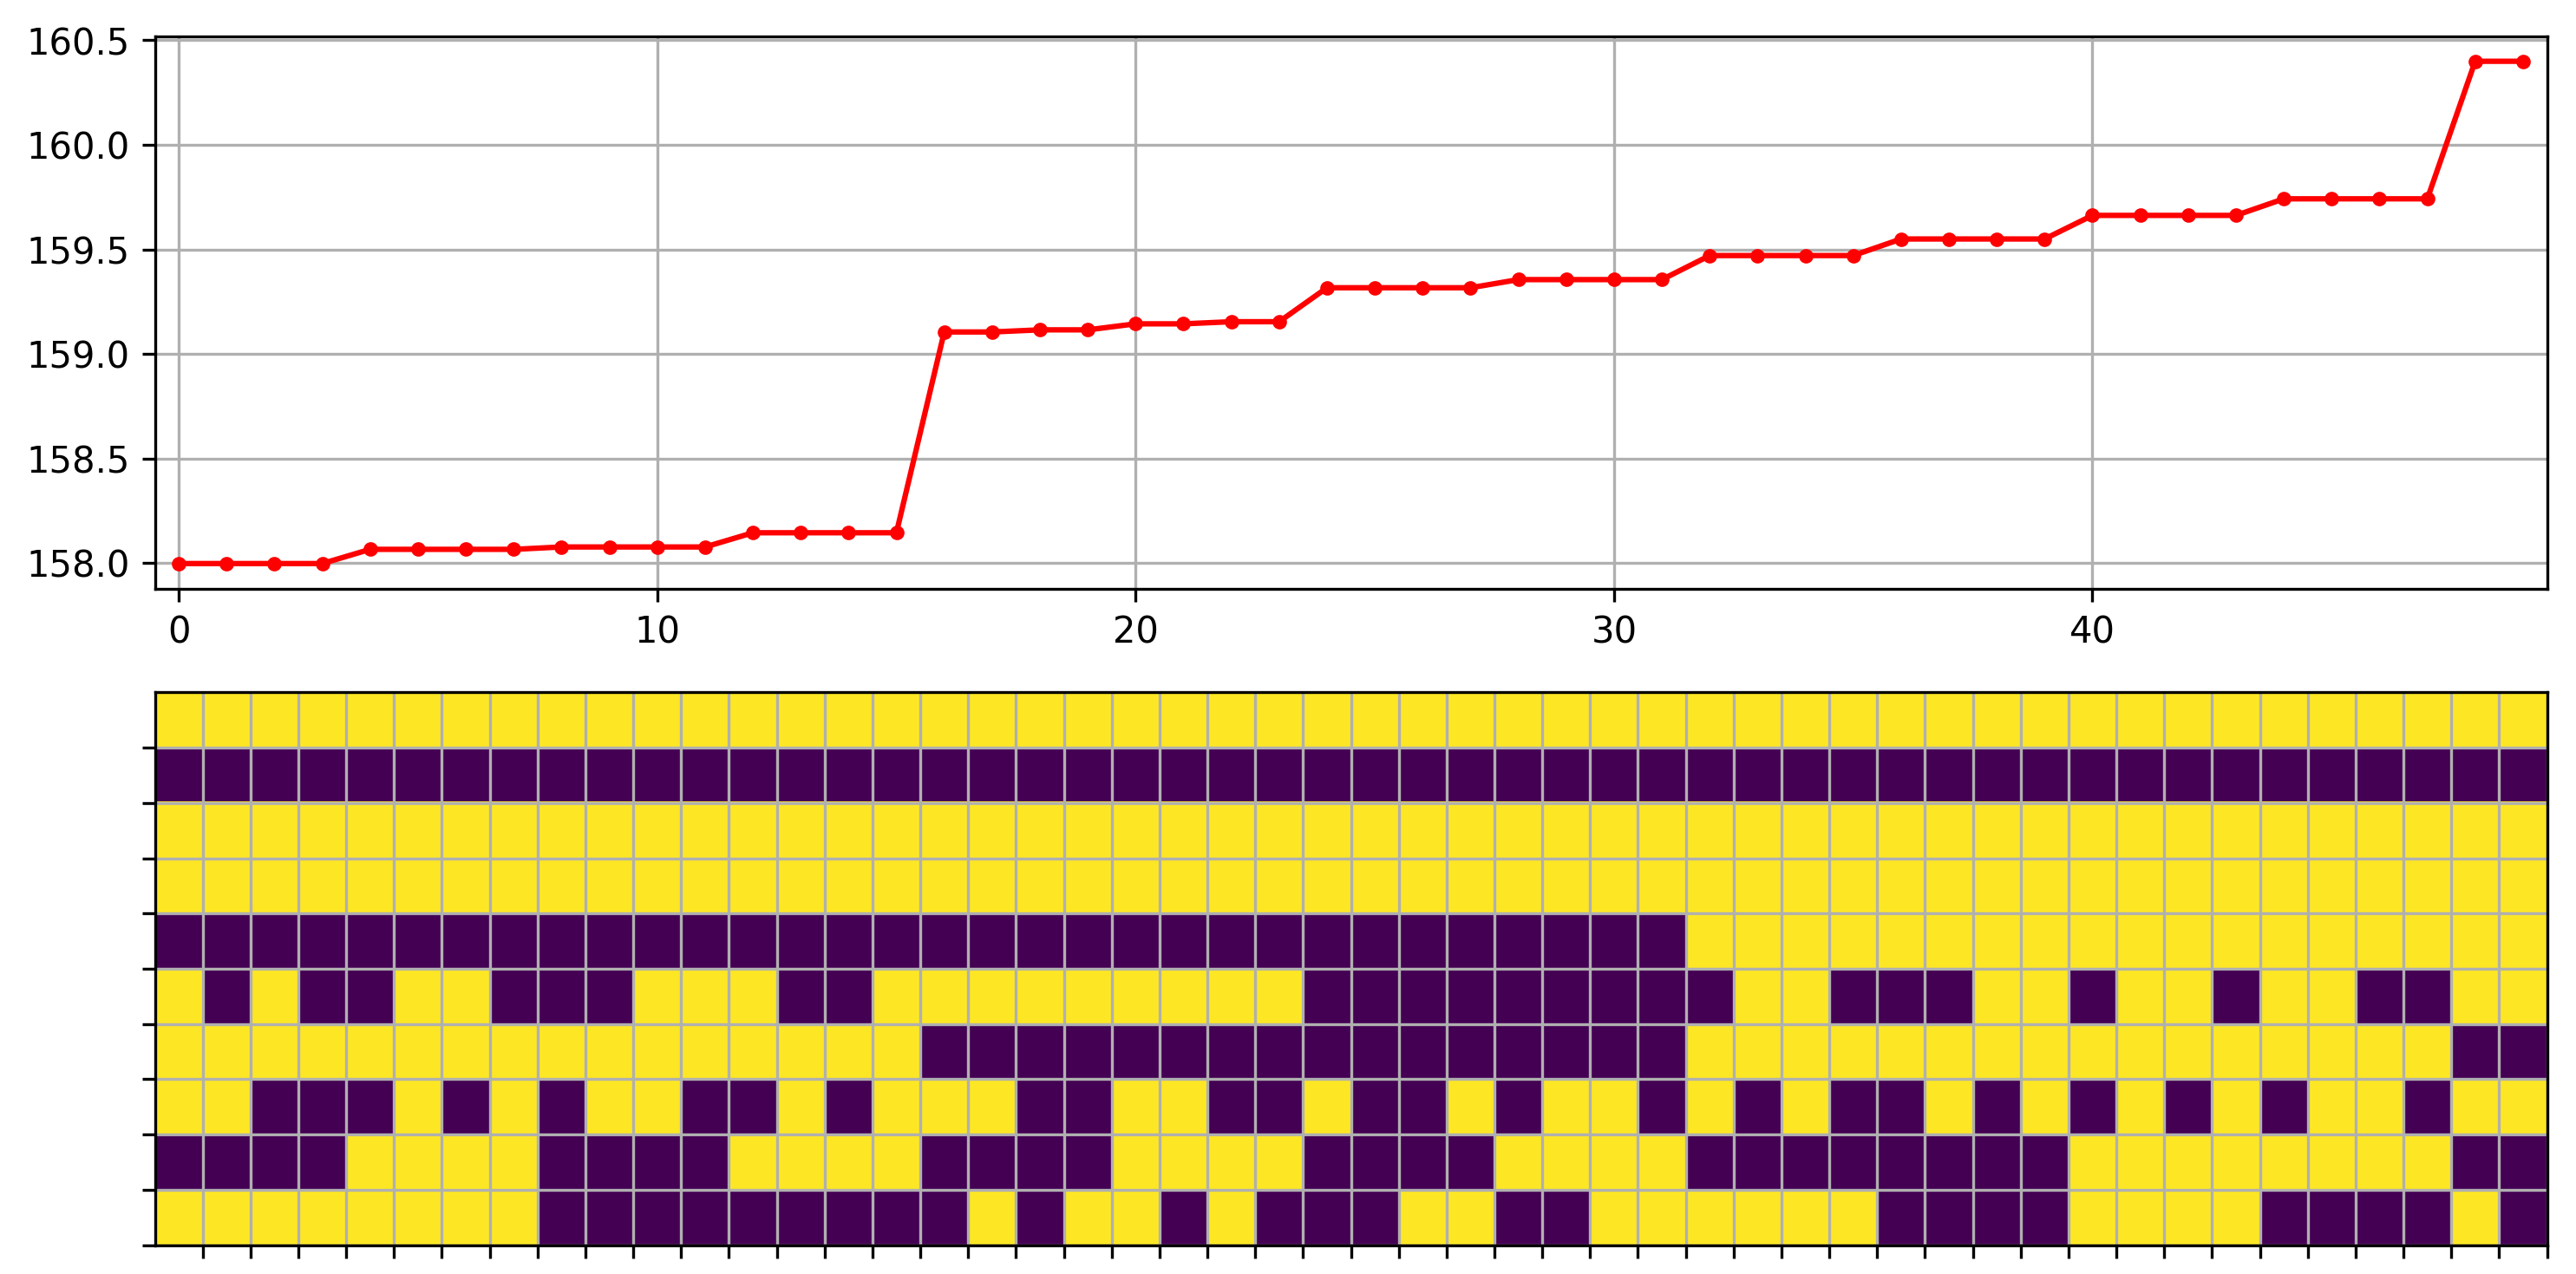

In [6]:
currents_plot(10, 
              list(conf10_values_sorted.values())[:50], 
              list(conf10_values_sorted.keys())[:50], 
              figsize=(10, 5), suffix='top30')

In [7]:
antenna_params["wavelengths"]=[1, 2]
antenna = Antenna(antenna_params)
antenna.set_configuration([1, 0, 1, 1, 0, 1, 1, 1, 0, 1])
antenna.set_positivity_bounds()
antenna.set_objective([1.0, 1.0])

In [8]:
antenna.get_optimal_current_allocation(opt_params, x0=-np.ones(antenna.N), cons=False)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  11   |   0   | +2.5731e+03 | 1.00e+00 | 2.82e+02 | 1.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  22   |   1   | +1.5164e+03 | 2.00e+00 | 2.07e+02 | 7.67e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |  33   |   2   | +3.4049e+02 | 1.40e+01 | 1.14e+02 | 2.78e-01 | 1.00e+00 |  1.00e-01   |   2   |
|   4   |  44   |   5   | +1.8547e+02 | 1.88e+01 | 3.36e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   |  55   |  11   | +1.6549e+02 | 1.88e+01 | 7.34e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   |  66   |  18   | +1.6040e+02 | 1.88e+01 | 2.95e+00 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |  77   |  24   | +1.5943e+02 | 1.88e+01 | 9.83e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |  88   |  32   | +1.5902e+02 | 1.88e+

/home/sergey/.conda/envs/kaggle/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


|  84   |  902  |  351  | +1.5800e+02 | 4.90e-01 | 1.09e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  85   |  913  |  355  | +1.5800e+02 | 4.90e-01 | 7.99e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  86   |  924  |  362  | +1.5800e+02 | 4.90e-01 | 1.73e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  87   |  935  |  365  | +1.5800e+02 | 4.90e-01 | 7.99e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  88   |  957  |  370  | +1.5800e+02 | 4.90e-02 | 7.99e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  89   |  968  |  375  | +1.5800e+02 | 4.90e-02 | 3.77e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  90   |  979  |  385  | +1.5800e+02 | 3.43e-01 | 6.70e-05 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   2   |
|  91   |  990  |  387  | +1.5800e+02 | 3.43e-01 | 6.47e-05 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  92   | 1001  |  390  | +1.5800e+02 | 3.43e-01 | 3.88e-05 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  93   | 1012  |  396  | +1.5800e+02 | 3.43e-

(157.99793240286158,
 array([9.71944335e-01, 3.09224921e-01, 5.86679570e-01, 2.04302786e-01,
        9.27448904e-02, 5.82697326e-08, 1.07878459e-01, 2.90850780e-08,
        1.97276360e-02, 2.25953775e-02]))

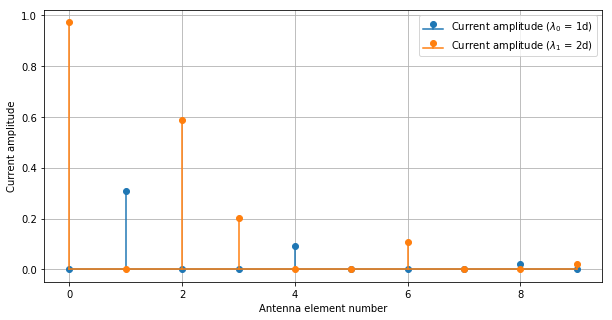

In [9]:
antenna.plot_current_distribution()

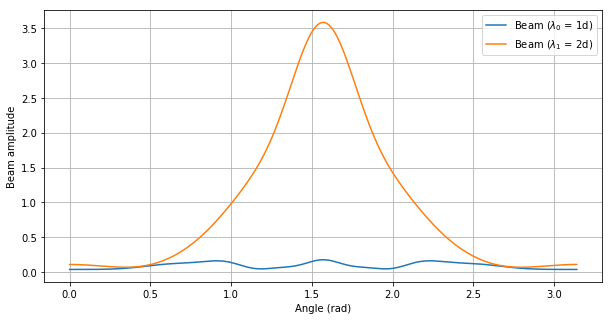

In [10]:
antenna.plot_formed_beams()

## 12 currents - all possible configurations

In [11]:
values12_num, conf12 = compute_possible_conf(12, jac=False, hess=False)
print(f"obj function value for the optimal configuration: {min(values12_num)}")

100%|██████████| 4096/4096 [38:09<00:00,  2.24it/s]  

obj function value for the optimal configuration: 167.08315284044033


In [12]:
save_data(12, values=values12_num, conf=conf12)

In [4]:
values12_num, conf12 = get_data(12)

In [13]:
conf12_values = get_conf_dict(values12_num, conf12)
conf12_values_sorted = sorted_repr(conf12_values)

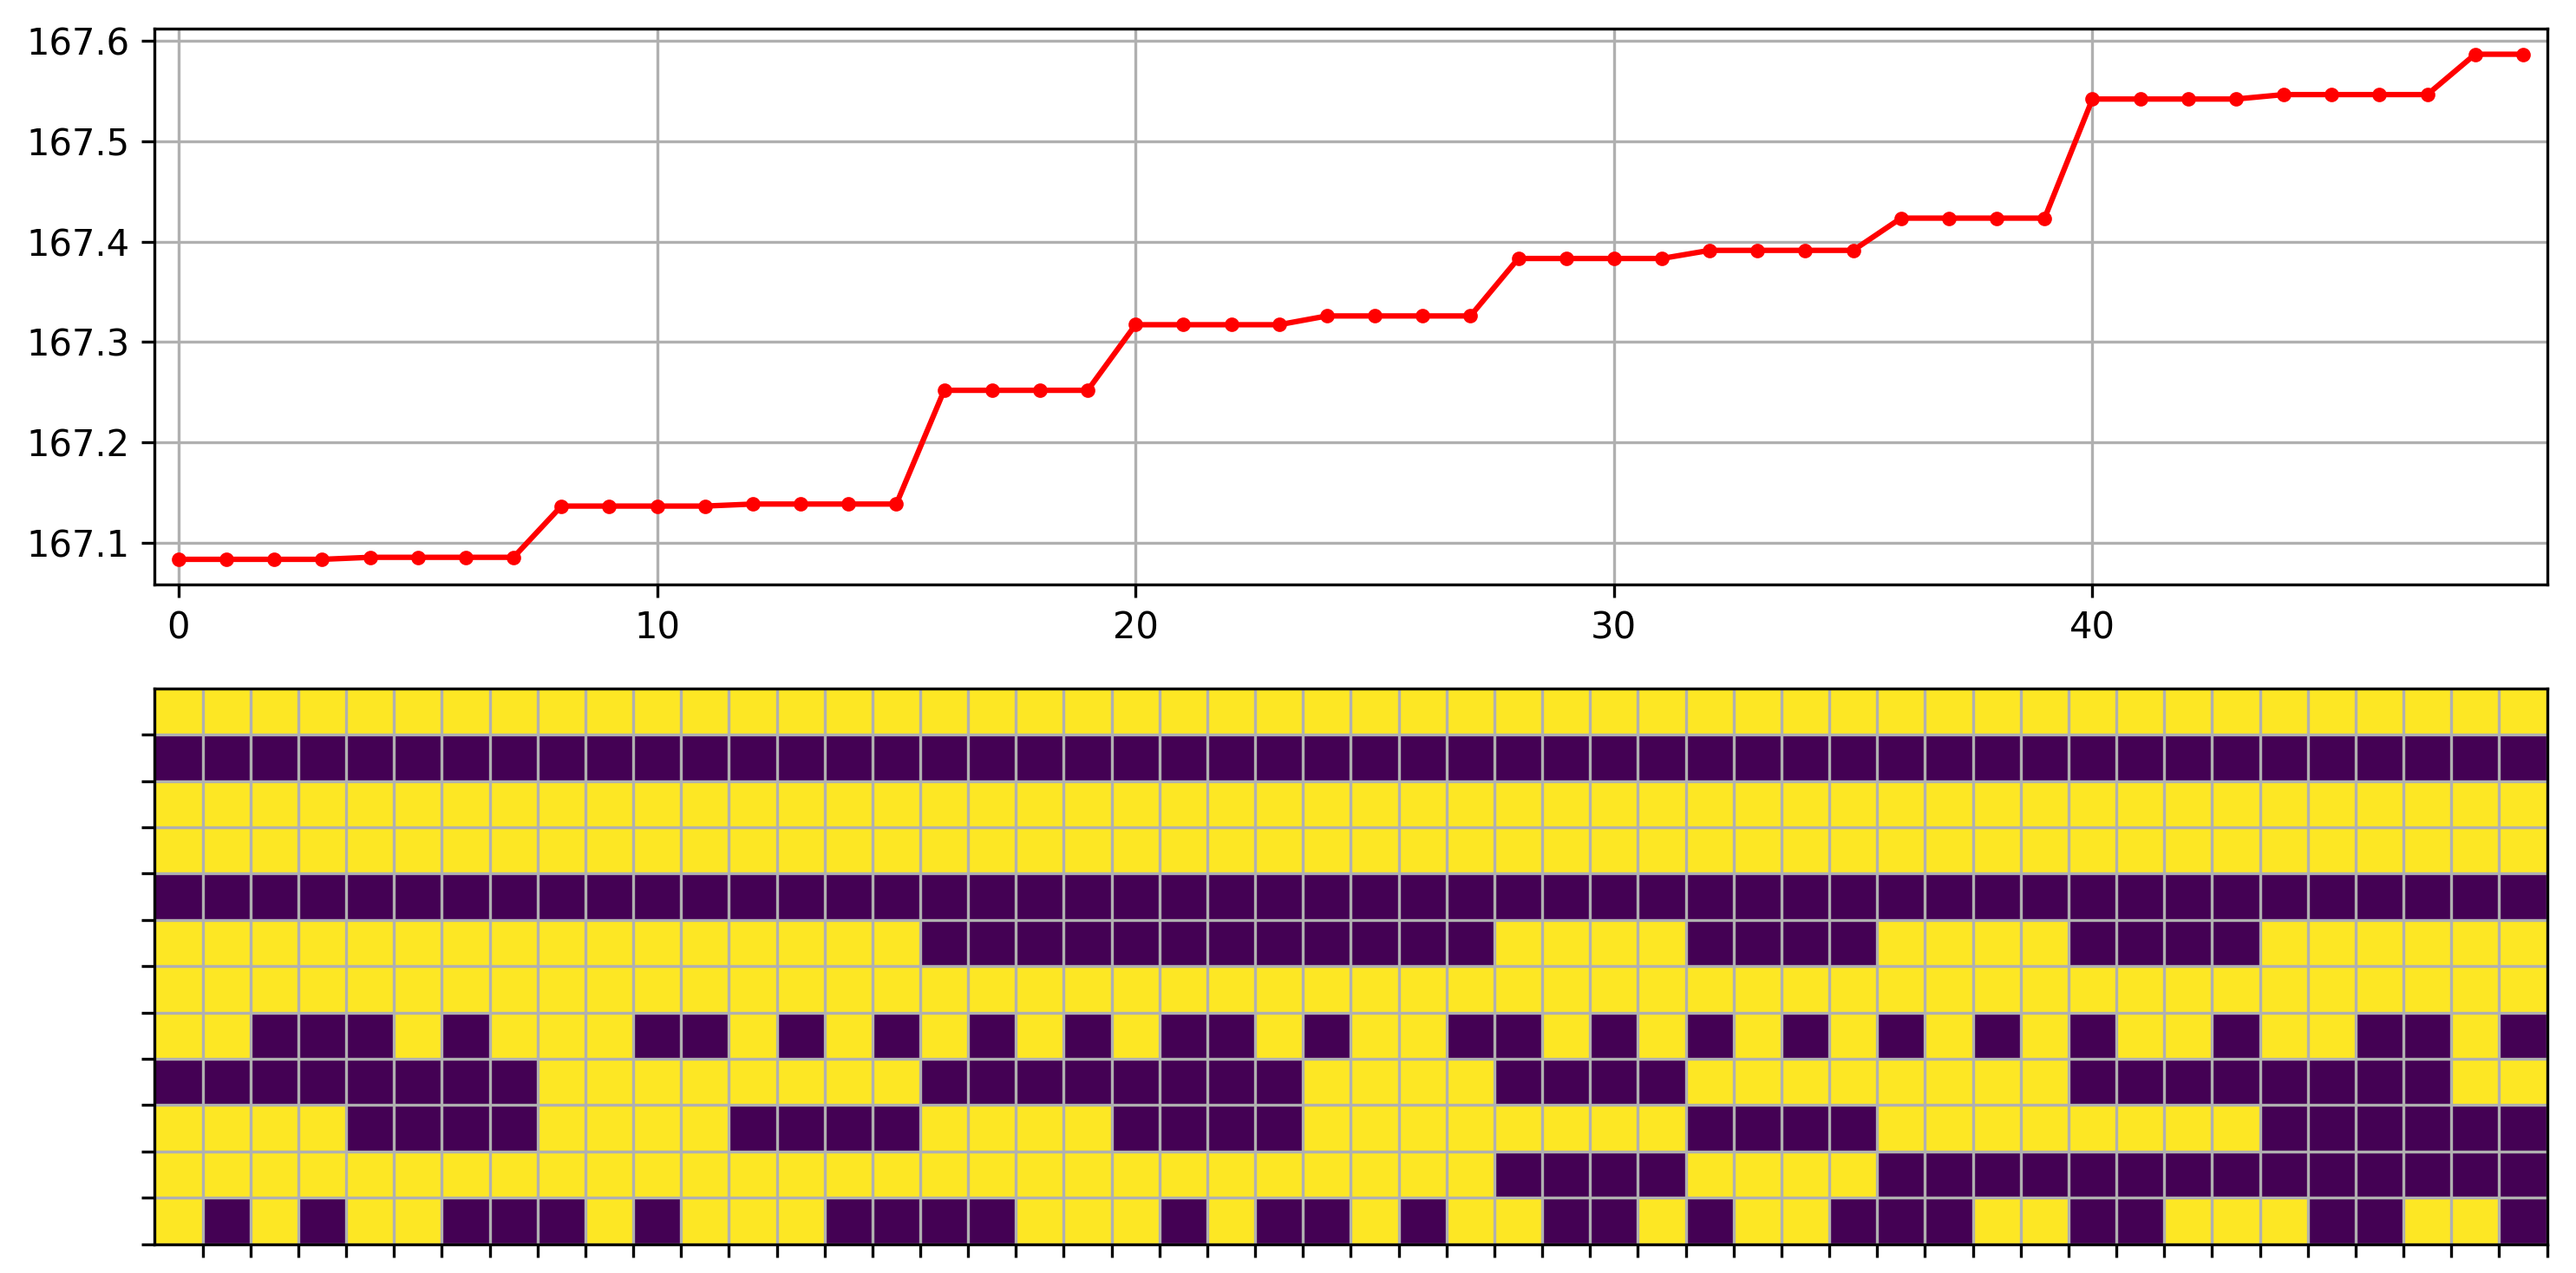

In [14]:
currents_plot(12, 
              list(conf12_values_sorted.values())[:50], 
              list(conf12_values_sorted.keys())[:50], 
              figsize=(10, 5), suffix='top30')

In [15]:
antenna_params["wavelengths"]=[1, 2]
antenna = Antenna(antenna_params)
antenna.set_configuration([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1])
antenna.set_positivity_bounds()
antenna.set_objective([1.0, 1.0])

In [16]:
antenna.get_optimal_current_allocation(opt_params, x0=-np.ones(antenna.N), cons=False)

(167.08315409489893,
 array([9.06243635e-01, 2.98655913e-01, 5.56876690e-01, 3.08203747e-01,
        1.30137996e-01, 5.61187066e-02, 9.27884241e-02, 4.72055614e-08,
        1.74407917e-02, 4.71309517e-03, 5.43534191e-02, 4.08655659e-08]))

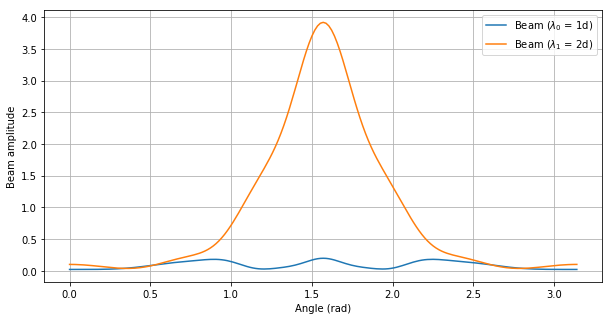

In [17]:
antenna.plot_formed_beams()